Load Modules

In [1]:
# Essential Imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

#Dataset repo
from ucimlrepo import fetch_ucirepo

# Models Import
from algorithms import CustomKNNClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Set HyperParameters

In [2]:
# KNN Classifier hyperparameters

k = 5
metric = 'euclidean'

In [3]:
classifiers = {
    'c1' : {
        'name' : 'CustomKNNClassifier',
        'model' : CustomKNNClassifier(k=k, metric=metric),
    },
    'c2' : {
        'name' : 'KNeighboursClassifier',
        'model' : KNeighborsClassifier(n_neighbors=k, metric=metric)
    },
    'c3' : {
        'name' : 'GaussianNB',
        'model' : GaussianNB()
    }
}

Import Dataset

In [4]:
dataset_dict = {
    0 : {
        'label' : 'd2',
        'name' : 'Breast Cancer',
        'data' : fetch_ucirepo(id=17)
    },
    1 : {
        'label' : 'd3',
        'name' : 'Wine Quality',
        'data' : fetch_ucirepo(id=186)
    }
}

In [5]:
class Classifier:
    """
    A wrapper class for training and evaluating machine learning models.

    Parameters:
        model (object): The machine learning model to be trained and evaluated.
        X_train (array-like): Training feature matrix.
        y_train (array-like): Training labels.
        X_test (array-like): Test feature matrix.
        y_true (array-like): True labels for the test set.
    """
    def __init__(self, model, X_train, y_train, X_test, y_true):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_true = y_true
        
        # attributes to store results and metric
        self.y_pred = None
        self.train_time = None
        self.predict_time = None
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.conf_matrix = None

    def fit(self):
        """
        Trains the model on the training data and records the training time.
        """
        start_train = time.time()
        self.model = self.model.fit(self.X_train,self.y_train)
        self.train_time = time.time() - start_train
    
    def predict(self):
        """
        Makes predictions on the test data, calculates prediction time, 
        and computes evaluation metrics.

        Returns:
            np.array: Predicted labels for the test set.
        """
        start_predict = time.time()
        self.y_pred = self.model.predict(self.X_test)
        self.predict_time = time.time() - start_predict

        
        if len(set(self.y_pred)) == 2:
            self._calculate_metrics(average='binary', pos_label=set(self.y_pred).pop())
        else:
            self._calculate_metrics(average='weighted')

        return self.y_pred
    
    def _calculate_metrics(self, average, pos_label=None):
        """
        Computes accuracy, precision, recall, and confusion matrix for the predictions.

        Args:
            average (str): Averaging method for precision and recall ('binary' or 'weighted').
            pos_label (int/str, optional): Positive class label for binary classification.
        """
        self.accuracy = accuracy_score(y_true=self.y_true, y_pred=self.y_pred)
        self.recall = recall_score(y_true=self.y_true, y_pred=self.y_pred, average=average,pos_label=pos_label)
        self.precision = precision_score(y_true=self.y_true, y_pred=self.y_pred, average=average, pos_label=pos_label)
        self.conf_matrix = confusion_matrix(y_true=self.y_true, y_pred=self.y_pred)


In [6]:
from sklearn.utils import shuffle

def weighted_data_split(X,y, test_size=0.2, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    X_train, X_test = [], []
    y_train, y_test = [], []

    classes = np.unique(y)
    # print(classes)

    for cls in classes:
        class_indices = np.where(y == cls)[0]
        class_samples = X[class_indices]
        class_labels = y[class_indices]

        # print(class_indices)

        class_samples, class_labels = shuffle(class_samples, class_labels, random_state=seed)
        split_idx = int(len(class_samples) * (1 - test_size))
        # print(split_idx)
        X_train.extend(class_samples[:split_idx])
        X_test.extend(class_samples[split_idx:])
        y_train.extend(class_labels[:split_idx])
        y_test.extend(class_labels[split_idx:])

    X_train, X_test = np.array(X_train) , np.array(X_test)
    y_train, y_test = np.array(y_train) , np.array(y_test)

    return X_train, X_test, y_train, y_test

In [7]:
from collections import Counter

for _, dataset in dataset_dict.items():
    X = dataset['data'].data.features.to_numpy()
    y = dataset['data'].data.targets.to_numpy().flatten()

    print(Counter(y))

    X_train, X_test, y_train, y_test = weighted_data_split(X, y, test_size=0.2)
    print(Counter(y_train.tolist()), Counter(y_test.tolist()))
    # print(Counter(X_test), Counter(y_test))

Counter({'B': 357, 'M': 212})
Counter({'B': 285, 'M': 169}) Counter({'B': 72, 'M': 43})
Counter({6: 2836, 5: 2138, 7: 1079, 4: 216, 8: 193, 3: 30, 9: 5})
Counter({6: 2268, 5: 1710, 7: 863, 4: 172, 8: 154, 3: 24, 9: 4}) Counter({6: 568, 5: 428, 7: 216, 4: 44, 8: 39, 3: 6, 9: 1})


Dataset - 1: Breast Cancer Wisconsin Diagnostic

In [8]:
# Data Load, Preprocessing and Splitting
wdbc = dataset_dict.get(0)

wdbc_label = wdbc['label']
wdbc_X = wdbc['data'].data.features.to_numpy()
wdbc_y = wdbc['data'].data.targets.to_numpy().flatten()


# Standardizing Features data
sc = StandardScaler()
wdbc_X = sc.fit_transform(wdbc_X)


# wdbc_X_train, wdbc_X_test, wdbc_y_train, wdbc_y_test = train_test_split(wdbc_X, wdbc_y, test_size=0.2, stratify=wdbc_y)
wdbc_X_train, wdbc_X_test, wdbc_y_train, wdbc_y_test = weighted_data_split(wdbc_X, wdbc_y, test_size=0.2)

print(wdbc_X_train.shape, wdbc_X_test.shape)
print(wdbc_y_train.shape, wdbc_y_test.shape)

(454, 30) (115, 30)
(454,) (115,)


Evaluate the models on Breast Cancer Dataset

Classifier -  CustomKNNClassifier  | Dataset - Breast Cancer
Test Accuracy -  0.9739130434782609
Recall Accuracy -  0.9302325581395349
Precision Accuracy -  1.0
Training time -  0.0
Prediction time -  0.2951700687408447
Confusion Matrix - 
 [[72  0]
 [ 3 40]]


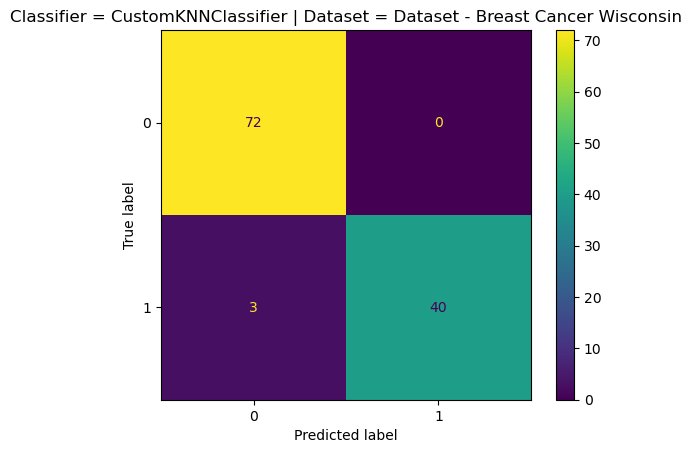

--------------------------------------------------
Classifier -  KNeighboursClassifier  | Dataset - Breast Cancer
Test Accuracy -  0.9739130434782609
Recall Accuracy -  0.9302325581395349
Precision Accuracy -  1.0
Training time -  0.0010225772857666016
Prediction time -  0.09437823295593262
Confusion Matrix - 
 [[72  0]
 [ 3 40]]


c:\Developer\miniconda3\envs\fdm\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Developer\miniconda3\envs\fdm\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Developer\miniconda3\envs\fdm\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Developer\miniconda3\envs\fdm\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Developer\miniconda3\envs\fdm\Lib\subprocess.py", line 1538, in _execute_child


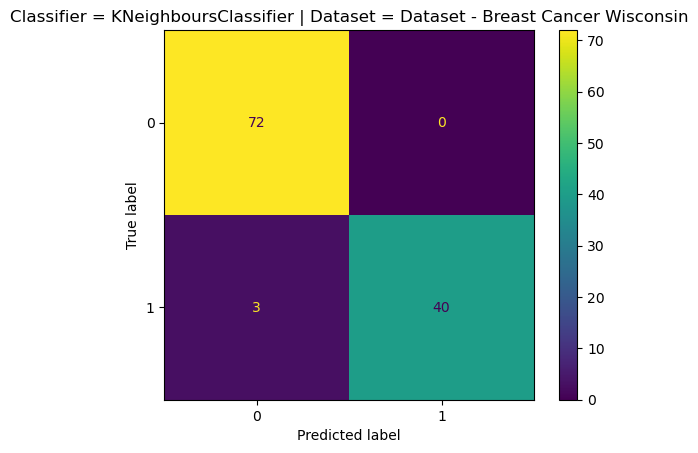

--------------------------------------------------
Classifier -  GaussianNB  | Dataset - Breast Cancer
Test Accuracy -  0.9130434782608695
Recall Accuracy -  0.9069767441860465
Precision Accuracy -  0.8666666666666667
Training time -  0.0009999275207519531
Prediction time -  0.0
Confusion Matrix - 
 [[66  6]
 [ 4 39]]


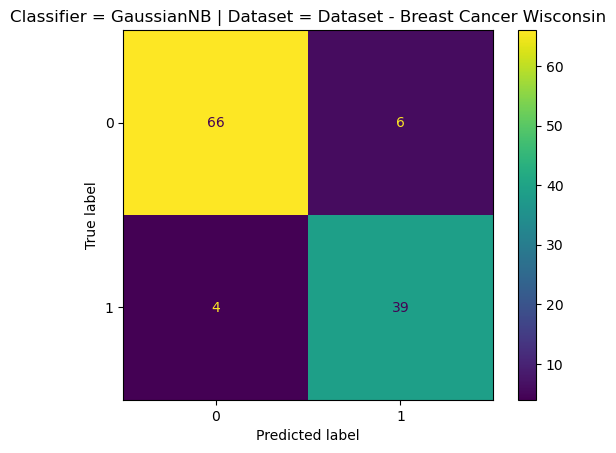

--------------------------------------------------


In [9]:
for cf_label, cf in classifiers.items():
    model = Classifier(model=cf['model'], X_train=wdbc_X_train, y_train=wdbc_y_train, X_test=wdbc_X_test, y_true=wdbc_y_test)

    model.fit()
    y_pred = model.predict()

    df = pd.DataFrame(model.conf_matrix,
                        index=[f'Actual_{i}' for i in range(model.conf_matrix.shape[0])],
                        columns=[f'Pred_{i}' for i in range(model.conf_matrix.shape[1])])
    
    df.to_csv(f'results/g008_{wdbc_label}_{cf_label}.csv')
    
    disp = ConfusionMatrixDisplay(confusion_matrix=model.conf_matrix)

    print('Classifier - ', cf['name'], ' | Dataset - Breast Cancer',)
    print('Test Accuracy - ', model.accuracy)
    print('Recall Accuracy - ', model.recall)
    print('Precision Accuracy - ', model.precision)
    print('Training time - ', model.train_time)
    print('Prediction time - ', model.predict_time)
    print(f'Confusion Matrix - \n', model.conf_matrix)
    disp.plot()

    plt.title(label=f'Classifier = {cf['name']} | Dataset = Dataset - Breast Cancer Wisconsin')
    plt.show()
    print('-' * 50)

Find Optimal k value

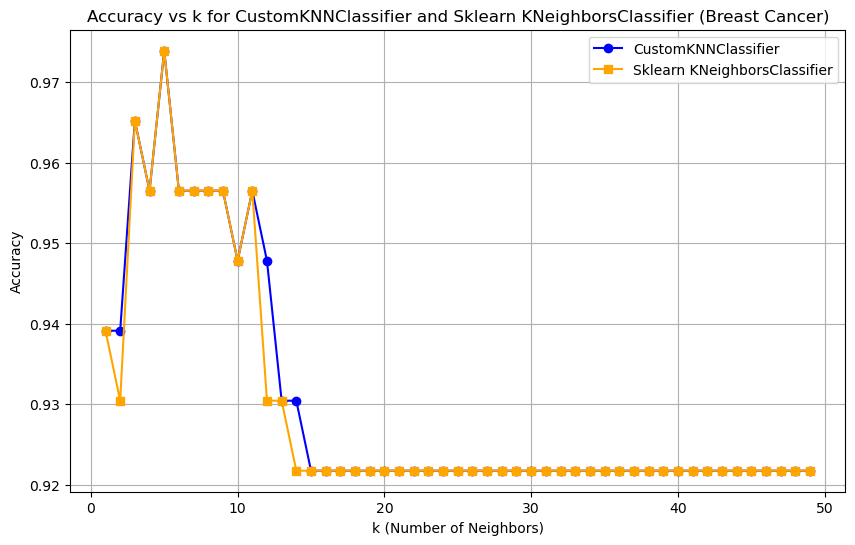

Optimal k for CustomKNNClassifier: 5, Accuracy: 0.9739
Optimal k for Sklearn KNeighborsClassifier: 5, Accuracy: 0.9739


In [10]:
# Range of k values to test
k_range = range(1, 50)

# Store cross-validation scores
custom_accuracies = []
sklearn_accuracies = []

# Perform cross-validation for each k for both classifiers
for k in k_range:
    # CustomKNNClassifier
    custom_knn = Classifier(model=CustomKNNClassifier(k=k, metric='euclidean'), X_train=wdbc_X_train, y_train=wdbc_y_train, X_test=wdbc_X_test, y_true=wdbc_y_test)
    custom_knn.fit()
    custom_knn_y_pred = custom_knn.predict()
    custom_accuracies.append(custom_knn.accuracy)

    # CustomKNNClassifier
    sklearn_knn = Classifier(model=KNeighborsClassifier(n_neighbors=k, metric='euclidean'), X_train=wdbc_X_train, y_train=wdbc_y_train, X_test=wdbc_X_test, y_true=wdbc_y_test)
    sklearn_knn.fit()
    sklearn_knn_y_pred = sklearn_knn.predict()
    sklearn_accuracies.append(sklearn_knn.accuracy)


    # custom_knn = CustomKNNClassifier(k=k)
    # custom_knn.fit(wdbc_X_train, wdbc_y_train)
    # custom_y_pred = custom_knn.predict(wdbc_X_test)
    # custom_acc = accuracy_score(y_true=y_test, y_pred=custom_y_pred)
    # custom_accuracies.append(custom_acc)

    # # Sklearn KNeighborsClassifier
    # sklearn_knn = KNeighborsClassifier(n_neighbors=k)
    # sklearn_knn.fit(wdbc_X_train, wdbc_y_train)
    # sklearn_y_pred = sklearn_knn.predict(X_test)
    # sklearn_acc = accuracy_score(y_true=y_test, y_pred=sklearn_y_pred)
    # sklearn_accuracies.append(sklearn_acc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, custom_accuracies, marker='o', label='CustomKNNClassifier', color='blue')
plt.plot(k_range, sklearn_accuracies, marker='s', label='Sklearn KNeighborsClassifier', color='orange')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k for CustomKNNClassifier and Sklearn KNeighborsClassifier (Breast Cancer)')
plt.legend()
plt.grid()
plt.show()

# Find the optimal k for each classifier
optimal_k_custom = k_range[np.argmax(custom_accuracies)]
optimal_k_sklearn = k_range[np.argmax(sklearn_accuracies)]
print(f"Optimal k for CustomKNNClassifier: {optimal_k_custom}, Accuracy: {max(custom_accuracies):.4f}")
print(f"Optimal k for Sklearn KNeighborsClassifier: {optimal_k_sklearn}, Accuracy: {max(sklearn_accuracies):.4f}")


Dataset - 2: Wine Quality

In [11]:
# Data Load, Preprocessing and Splitting
wine_quality = dataset_dict.get(1)

wine_quality_label = wine_quality['label']
wine_quality_X = wine_quality['data'].data.features.to_numpy()
wine_quality_y = wine_quality['data'].data.targets.to_numpy().flatten()


# Standardizing Features data
sc = StandardScaler()
wine_quality_X = sc.fit_transform(wine_quality_X)


# wine_quality_X_train, wine_quality_X_test, wine_quality_y_train, wine_quality_y_test = train_test_split(wine_quality_X, wine_quality_y, test_size=0.2, stratify=wine_quality_y)
wine_quality_X_train, wine_quality_X_test, wine_quality_y_train, wine_quality_y_test = weighted_data_split(wine_quality_X, wine_quality_y, test_size=0.2)

print(wine_quality_X_train.shape, wine_quality_X_test.shape)

(5195, 11) (1302, 11)


Evaluate the models on Wine Quality

Classifier -  CustomKNNClassifier  | Dataset - Wine Quality
Test Accuracy -  0.5714285714285714
Recall Accuracy -  0.5714285714285714
Precision Accuracy -  0.5652956102118584
Training time -  0.0
Prediction time -  35.18489933013916
Confusion Matrix - 
 [[  0   0   1   5   0   0   0]
 [  0   5  21  16   2   0   0]
 [  0   3 261 143  19   2   0]
 [  0   1 123 373  67   4   0]
 [  0   0  10 105  98   3   0]
 [  0   0   1  15  16   7   0]
 [  0   0   1   0   0   0   0]]


c:\Developer\miniconda3\envs\fdm\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


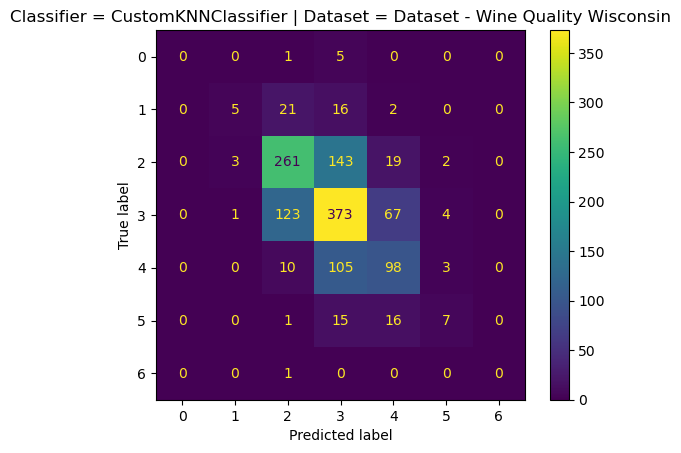

--------------------------------------------------
Classifier -  KNeighboursClassifier  | Dataset - Wine Quality
Test Accuracy -  0.5645161290322581
Recall Accuracy -  0.5645161290322581
Precision Accuracy -  0.552022611424305
Training time -  0.0061261653900146484
Prediction time -  0.10923290252685547
Confusion Matrix - 
 [[  0   0   2   4   0   0   0]
 [  0   6  23  13   2   0   0]
 [  0   5 271 137  13   2   0]
 [  0   4 142 362  57   3   0]
 [  0   0  14 109  92   1   0]
 [  0   0   3  16  16   4   0]
 [  0   0   1   0   0   0   0]]


c:\Developer\miniconda3\envs\fdm\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


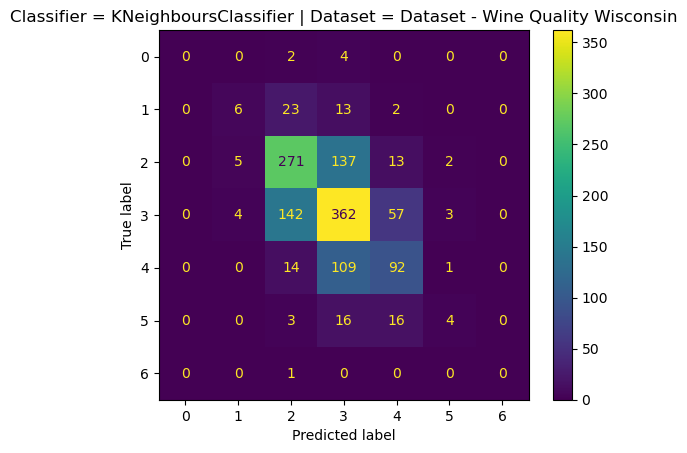

--------------------------------------------------
Classifier -  GaussianNB  | Dataset - Wine Quality
Test Accuracy -  0.4539170506912442
Recall Accuracy -  0.4539170506912442
Precision Accuracy -  0.4531593592175811
Training time -  0.0019969940185546875
Prediction time -  0.0009982585906982422
Confusion Matrix - 
 [[  0   1   4   0   1   0   0]
 [  0   5  20  16   3   0   0]
 [  2   5 235 156  30   0   0]
 [  1  15 151 237 156   4   4]
 [  1   4  15  74 114   6   2]
 [  0   0   4   8  26   0   1]
 [  0   0   0   1   0   0   0]]


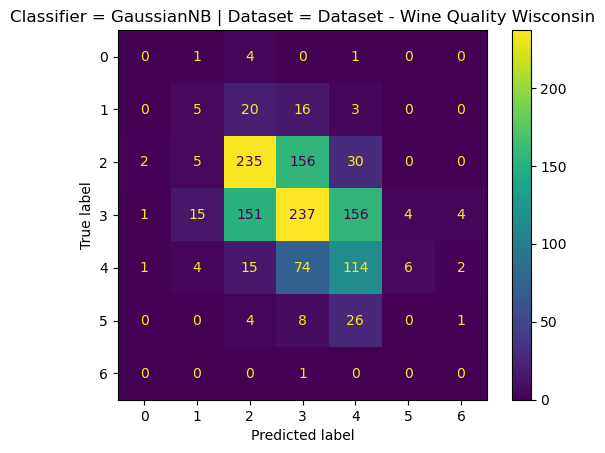

--------------------------------------------------


In [12]:
for cf_label, cf in classifiers.items():
    model = Classifier(model=cf['model'], X_train=wine_quality_X_train, y_train=wine_quality_y_train, X_test=wine_quality_X_test, y_true=wine_quality_y_test)

    model.fit()
    y_pred = model.predict()

    df = pd.DataFrame(model.conf_matrix,
                        index=[f'Actual_{i}' for i in range(model.conf_matrix.shape[0])],
                        columns=[f'Pred_{i}' for i in range(model.conf_matrix.shape[1])])
    
    df.to_csv(f'results/g008_{wine_quality_label}_{cf_label}.csv')
    
    disp = ConfusionMatrixDisplay(confusion_matrix=model.conf_matrix)

    print('Classifier - ', cf['name'], ' | Dataset - Wine Quality',)
    print('Test Accuracy - ', model.accuracy)
    print('Recall Accuracy - ', model.recall)
    print('Precision Accuracy - ', model.precision)
    print('Training time - ', model.train_time)
    print('Prediction time - ', model.predict_time)
    print(f'Confusion Matrix - \n', model.conf_matrix)
    disp.plot()

    plt.title(label=f'Classifier = {cf['name']} | Dataset = Dataset - Wine Quality Wisconsin')
    plt.show()
    print('-' * 50)

Find Optimal k value

c:\Developer\miniconda3\envs\fdm\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Developer\miniconda3\envs\fdm\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Developer\miniconda3\envs\fdm\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Developer\min

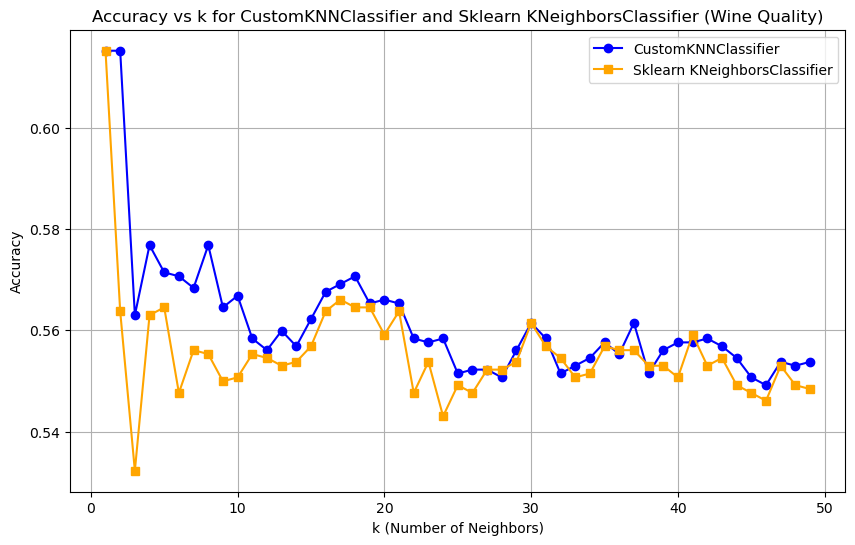

Optimal k for CustomKNNClassifier: 1, Accuracy: 0.6152
Optimal k for Sklearn KNeighborsClassifier: 1, Accuracy: 0.6152


In [13]:
# Range of k values to test
k_range = range(1, 50)

# Store cross-validation scores
custom_accuracies = []
sklearn_accuracies = []

# Perform cross-validation for each k for both classifiers
for k in k_range:
    # CustomKNNClassifier
    custom_knn = Classifier(model=CustomKNNClassifier(k=k, metric='euclidean'), X_train=wine_quality_X_train, y_train=wine_quality_y_train, X_test=wine_quality_X_test, y_true=wine_quality_y_test)
    custom_knn.fit()
    custom_knn_y_pred = custom_knn.predict()
    custom_accuracies.append(custom_knn.accuracy)

    # CustomKNNClassifier
    sklearn_knn = Classifier(model=KNeighborsClassifier(n_neighbors=k, metric='euclidean'), X_train=wine_quality_X_train, y_train=wine_quality_y_train, X_test=wine_quality_X_test, y_true=wine_quality_y_test)
    sklearn_knn.fit()
    sklearn_knn_y_pred = sklearn_knn.predict()
    sklearn_accuracies.append(sklearn_knn.accuracy)


    # custom_knn = CustomKNNClassifier(k=k)
    # custom_knn.fit(wine_quality_X_train, wine_quality_y_train)
    # custom_y_pred = custom_knn.predict(wine_quality_X_test)
    # custom_acc = accuracy_score(y_true=y_test, y_pred=custom_y_pred)
    # custom_accuracies.append(custom_acc)

    # # Sklearn KNeighborsClassifier
    # sklearn_knn = KNeighborsClassifier(n_neighbors=k)
    # sklearn_knn.fit(wine_quality_X_train, wine_quality_y_train)
    # sklearn_y_pred = sklearn_knn.predict(X_test)
    # sklearn_acc = accuracy_score(y_true=y_test, y_pred=sklearn_y_pred)
    # sklearn_accuracies.append(sklearn_acc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, custom_accuracies, marker='o', label='CustomKNNClassifier', color='blue')
plt.plot(k_range, sklearn_accuracies, marker='s', label='Sklearn KNeighborsClassifier', color='orange')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k for CustomKNNClassifier and Sklearn KNeighborsClassifier (Wine Quality)')
plt.legend()
plt.grid()
plt.show()

# Find the optimal k for each classifier
optimal_k_custom = k_range[np.argmax(custom_accuracies)]
optimal_k_sklearn = k_range[np.argmax(sklearn_accuracies)]
print(f"Optimal k for CustomKNNClassifier: {optimal_k_custom}, Accuracy: {max(custom_accuracies):.4f}")
print(f"Optimal k for Sklearn KNeighborsClassifier: {optimal_k_sklearn}, Accuracy: {max(sklearn_accuracies):.4f}")

In [14]:
# for _, dataset in dataset_dict.items():
#     X = dataset['data'].data.features.to_numpy()
#     y = dataset['data'].data.targets.to_numpy().flatten()

#     sc = StandardScaler()
#     X = sc.fit_transform(X)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#     for _, cf in classifiers.items():
#         model = Classifier(model=cf['model'],X_train=X_train, y_train=y_train, X_test=X_test, y_true=y_test)

#         model.fit()
#         y_pred = model.predict()

#         df = pd.DataFrame(model.conf_matrix,
#                           index=[f'Actual_{i}' for i in range(model.conf_matrix.shape[0])],
#                           columns=[f'Predicted_{i}' for i in range(model.conf_matrix.shape[1])])
        
#         df.to_csv(f'results/g018_{dataset['label']}_{cf['label']}.csv')
        
#         disp = ConfusionMatrixDisplay(confusion_matrix=model.conf_matrix)

#         print('Classifier - ', cf['name'], ' | Dataset - ', dataset['name'])
#         print('Test Accuracy - ', model.accuracy)
#         print('Recall Accuracy - ', model.recall)
#         print('Precision Accuracy - ', model.precision)
#         print('Training time - ', model.train_time)
#         print('Prediction time - ', model.predict_time)
#         print(f'Confusion Matrix - \n', model.conf_matrix)
#         disp.plot()

#         plt.title(label=f'Classifier = {cf['name']} | Dataset = {dataset['name']}')
#         plt.show()
#         print('-' * 50)